In [1]:
import os 
cwd = os.getcwd()
import sys
sys.path.append("C:/Users/gomel/Documents/global_python_codes/Metrics_thresholds_boots") # go to parent dir
import sympy as sp
import ewstools as ews
import numpy as np
import sdeint
import metrics
import boots as bts
import scipy.stats as st
import astropy.stats as astrost
import scipy.signal as sg

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif"
})

import matplotlib.lines as lines
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']


c1=(221/256,170/256,51/256)
c2=(187/256,85/256,102/256)
c3=(0,68/256,136/256)
cols=(c1,c2,c3)

This is a simulation of a onlinear equation with aditive noise using a Heun method where the noise only applies on the variable and not the parameter. 

\begin{equation}
\dot{x}=-\lambda x
\end{equation}

where $x$ is a random variable and $\lambda$ is a swiped parameter determined by $\dot{\lambda}=\lambda$.  


This system has three fixed points, $x^*={0}$.




variance: 0.38915321922534085
estimated variance: 0.5


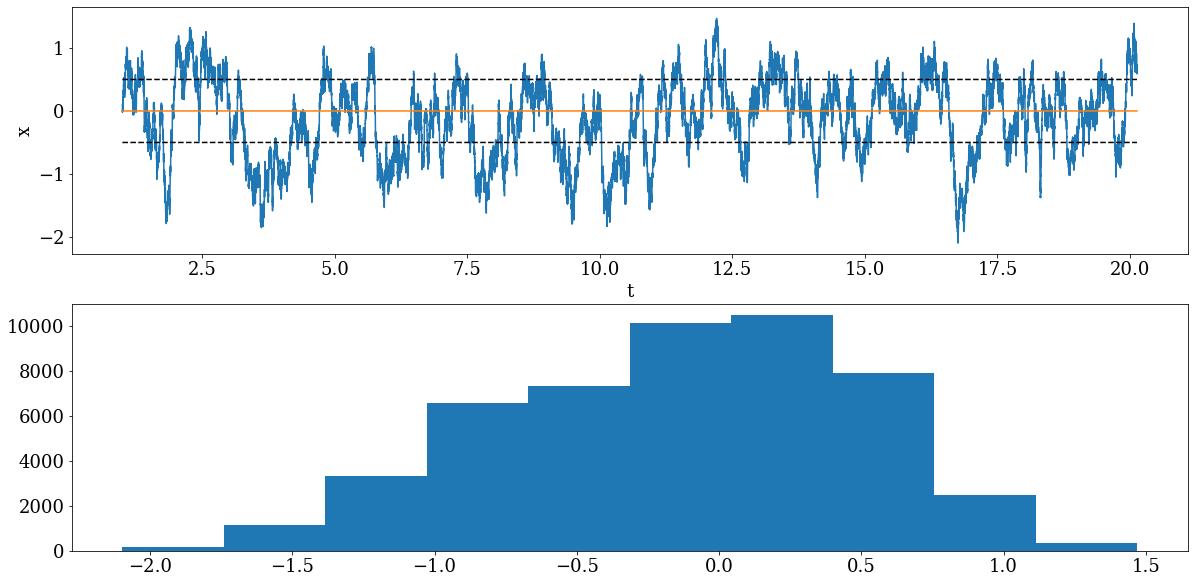

In [2]:
s=2
B = np.diag([s]) # diagonal, so independent driving Wiener processes
tspan = np.linspace(1.0, 20.13, 50001)
x0 = np.array([.0])

def f(x, t):
    #X=x[0]. dot(x)=rx-x^3
    #r=x[1]. dot(r)=cte.  This is a constant swipe of parameter r at speed dot(r). 
    l=4
    A=np.array([ -l*x[0] ])
    return A

def G(x, t):
    #B=[ 'noise in x'         0    ]
    #  [      0        'noise in r']
    #the only parameter with relevant aditive noise is X(t) in this case. 
    return B

result = sdeint.stratHeun(f, G, x0, tspan)


import matplotlib.pyplot as plt
fig=plt.figure(figsize=(20,10))
fig.add_subplot(211)
plt.plot(tspan,result)
plt.plot(tspan,0*tspan+s**2/(2*4),'--',color='black')
plt.plot(tspan,0*tspan-s**2/(2*4),'--',color='black')

plt.plot(tspan,0*result)
plt.ylabel('x')
plt.xlabel('t')

fig.add_subplot(212)
plt.hist(result)

200*tspan[-1]
print('variance:',np.var(result))
print('estimated variance:',s**2/(2*4))



The stochastic equation is 

\begin{equation}
\begin{aligned}
dx & =-\lambda x \, dt +\sigma dW\\
d\lambda & =\lambda dt
\end{aligned}
\end{equation}

where W is a (0,1) white noise process and $\sigma$ the intensity of the noise. Here $\dot{x}=-\lambda x$ is called the deterministic skeleton of the stochastic equation.

$M=f'(x^*)$

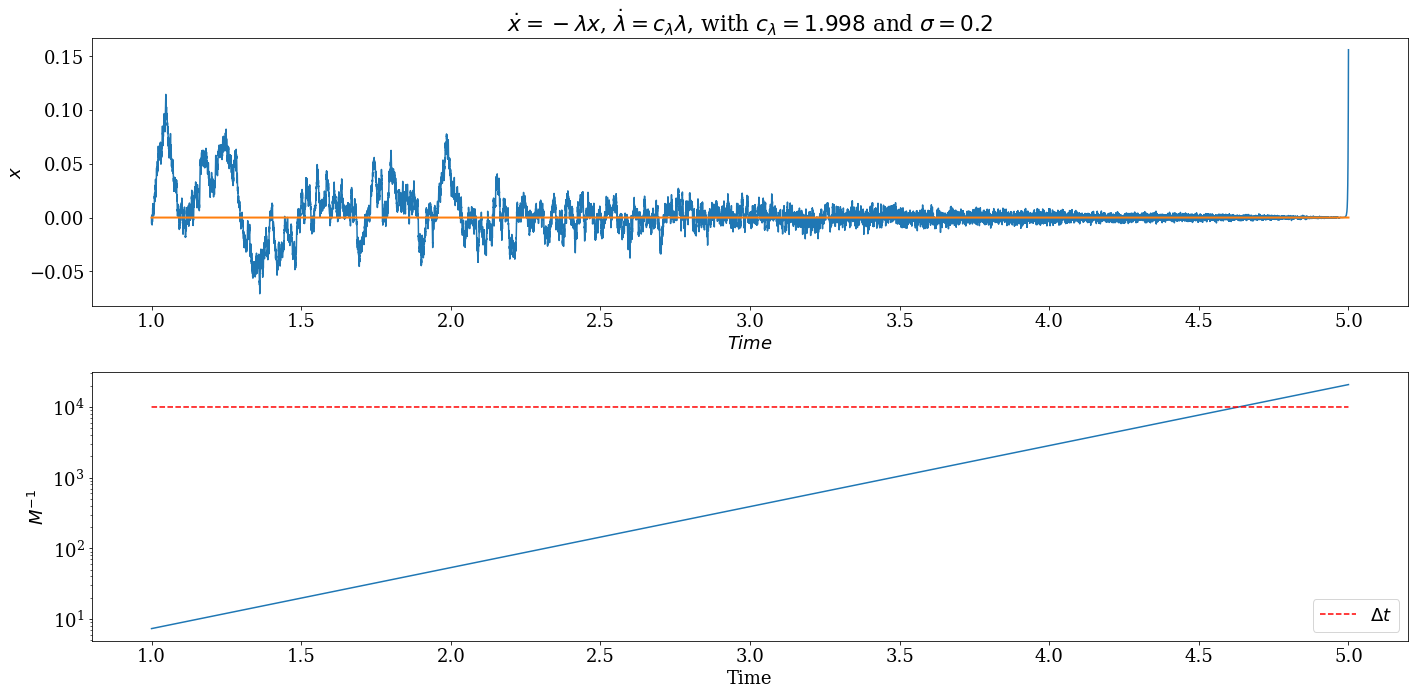

In [3]:
s=0.2
B = np.diag([s]) # diagonal, so independent driving Wiener processes

tspan = np.linspace(1.0, 5.0, 40001)
x0 = np.array([.0])
cl=1.988
def f(x, t):
    #X=x[0]. dot(x)=rx-x^3
    #r=x[1]. dot(r)=cte.  This is a constant swipe of parameter r at speed dot(r). 
    l=np.exp(cl*t)
    A=np.array([ -l*x[0] ])
    return A

def G(x, t):
    #B=[ 'noise in x'         0    ]
    #  [      0        'noise in r']
    #the only parameter with relevant aditive noise is X(t) in this case. 
    return B
l=np.exp(1.988*tspan)
result = sdeint.stratHeun(f, G, x0, tspan)

fig=plt.figure(figsize=(20,10))
fig.add_subplot(211)
plt.plot(tspan,result)
#plt.plot(tspan,0*tspan+s**2/(2),'--',color='black',label=r'$\frac{sigma^2}{2 M}$')
#plt.plot(tspan,0*tspan-s**2/(2*l),'--',color='black')

plt.plot(tspan,0*result,linewidth=2,label='$x^*$')
plt.title(r'$\dot x=-\lambda x$, $\dot \lambda=c_{\lambda}\lambda$, with $c_{\lambda}=1.998$ and $\sigma=0.2$')
plt.ylabel('$x$')
plt.xlabel('$Time$')

fig.add_subplot(212)
plt.semilogy(tspan,np.exp(1.988*tspan))
plt.semilogy(tspan,tspan*0+1/(tspan[1]-tspan[0]),'--',color='red',label='$\Delta t$')
plt.xlabel('Time')
plt.ylabel('$M^{-1}$')
plt.legend()
plt.tight_layout()
fig.savefig('./image_variance_speed/time_step_divergence.png'  , dpi = 100)# when saving, specify the DPI\n",


If i ask that $\Delta t<t^*=-1/f'(x^*)$:

In [4]:
l_t=np.exp(0.9*tspan)
t_relax=-1/max(l_t)

print(r'$t^*$=', t_relax )
print(r'$\Delta t= $', tspan[1]-tspan[0])


$t^*$= -0.011108996538242306
$\Delta t= $ 9.999999999998899e-05


## Testing the variance on an ensemble of runs vs. parameter speed.

In [5]:
runs=result

skew=np.zeros([len(tspan)])
mean=np.zeros([len(tspan)])

var=np.zeros([len(tspan)])
kur=np.zeros([len(tspan)])
hogg2=np.zeros([len(tspan)])
moors=np.zeros([len(tspan)])
#    rri[n]=metrics.metric_rri(x[n*win:(n+1)*win])
    # brtw=boots.bootstrap_func_len(metrics.RTW_max, x[n*win:(n+1)*win], 20)
RTW=np.zeros([len(tspan)])
#skew_runs=np.zeros([len(tspan),nruns])
np.zeros([len(tspan)])
for j in range(len(tspan)):
    skew[j]= st.skew(runs[j,:])
    var[j]= np.var(runs[j,:])
    kur[j]=st.kurtosis(runs[j,:])
    mean[j]=np.mean(runs[j,:])
    try:
        hogg2[j]= metrics.Hoor2(runs[j,:])
        moors[j]= metrics.Moors(runs[j,:])
    except:
        continue
    RTW[j]= metrics.RTW_max(runs[j,:])
    

Text(0.5, 1.0, 'Mean')

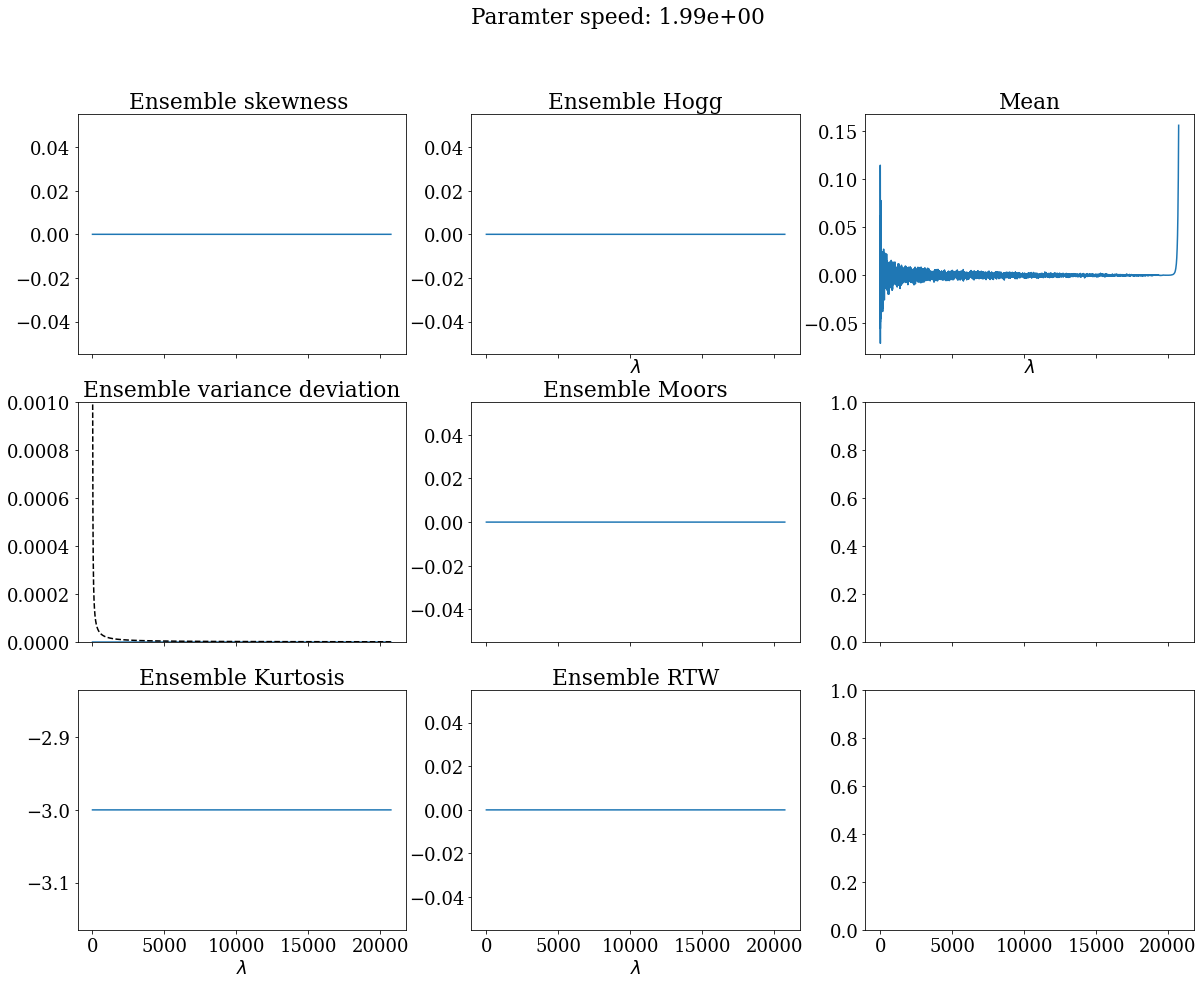

In [6]:
'''plot stats'''

fig, ax = plt.subplots(3, 3, sharex='col',figsize=(20,15))

plt.suptitle('Paramter speed: %.2e' %(cl))
axs=ax[0,0]

axs.plot(l,skew)
axs.set_title('Ensemble skewness ')
axs=ax[1,0]

axs.plot(l,var)
axs.set_ylim([0,0.001])
axs.plot(l,s**2/(2*l),'--',color='black')
axs.set_title('Ensemble variance deviation')

axs=ax[2,0]
axs.plot(l,kur)
axs.set_xlabel(r'$\lambda$')
axs.set_title('Ensemble Kurtosis')

axs=ax[0,1]
axs.plot(l,hogg2)
axs.set_xlabel(r'$\lambda$')
axs.set_title('Ensemble Hogg')

axs=ax[1,1]
axs.plot(l,moors)
axs.set_title('Ensemble Moors')

axs=ax[2,1]
axs.plot(l,RTW)
axs.set_xlabel(r'$\lambda$')
axs.set_title('Ensemble RTW')

axs=ax[0,2]
axs.plot(l,mean)
axs.set_xlabel(r'$\lambda$')
axs.set_title('Mean')


This part of the code fixed a grid in time and calculates the variance for 20 $c_\lambda$ going from $c_\lambda={ 2, ..., 0.001 }$

array([2.00000000e+00, 1.34057642e+00, 8.98572564e-01, 6.02302593e-01,
       4.03716326e-01, 2.70606293e-01, 1.81384207e-01, 1.21579695e-01,
       8.14934360e-02, 5.46240892e-02, 3.66138828e-02, 2.45418539e-02,
       1.64501153e-02, 1.10263183e-02, 7.39081113e-03, 4.95397355e-03,
       3.32059005e-03, 2.22575236e-03, 1.49189556e-03, 1.00000000e-03])

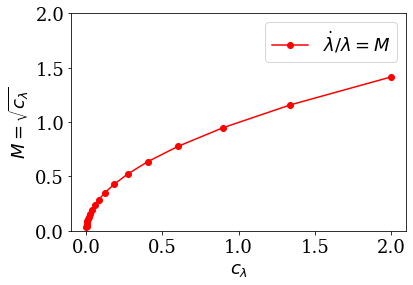

In [7]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

s=0.02 #noise process intensity
B = np.diag([s]) # diagonal, so independent driving Wiener processes

l0=3 #Initial lambda
lf=.001 #Final lambda

def f(x, t):
    #X=x[0]. dot(x)=rx-x^3
    #r=x[1]. dot(r)=cte.  This is a constant swipe of parameter r at speed dot(r). 
    l=l0+cl*t
    A=np.array([ -l*x[0] ])
    return A
def G(x, t):
    #B=[ 'noise in x'         0    ]
    #  [      0        'noise in r']
    #the only parameter with relevant aditive noise is X(t) in this case. 
    return B  

np.random.seed(1) #set numpy.random seed for reproducibility whenever it might be used.

''' evely spaced values in log scale'''
cl_var=np.logspace( np.log10(2),-3, num=20, endpoint=True, base=10.0, dtype='float64', axis=0)
l_var=np.linspace(lf,l0,20)
fig=plt.figure()
plt.plot(cl_var,np.sqrt(cl_var),'-o',color='red',label=r'$\dot \lambda/ \lambda = M $')
plt.legend()
plt.ylim([-0.001,2])
plt.xlabel(r'$c_\lambda$')
plt.ylabel(r'$M=\sqrt{c_\lambda}$')
fig.savefig('./image_variance_speed/proposed relationship.png'  , dpi = 100)# when saving, specify the DPI\n",
cl_var

In [9]:
############################################################## set cl and tspan #######################
for jrun in range(len(cl_var)):
    cl=np.sign(lf-l0)*cl_var[jrun] #from the previous result
    t_final=(lf-l0)/cl
    t_rm=1/l0
    t_threshold=t_rm/2

    datalen=t_final/(600*7*3)
    if datalen>=t_threshold/2: 
        datalen=t_threshold/2

    tspan=np.arange(0,t_final,datalen)

    print(r'$\Delta t= $', tspan[1]-tspan[0], 't_final:', t_final)
    print('data length: ', len(tspan))
    print('dot lambda: ', cl)

    ############################################################## integrations #######################
    nruns=300
    results=np.zeros([len(tspan),nruns])
    for i in range(nruns):
        #initial condition is random with the equilibrium variance so all points don't start toghether:
        x0= np.array([np.random.normal(0.,np.sqrt(s**2/(2*l0)))]) 
        x0= np.array([0.]) 

        #integration
        res=sdeint.stratHeun(f, G, x0, tspan)
        results[:,i] = res[:,0]
    l=l0+cl*tspan
    dl=cl*tspan[1]-l0
    print('Integration DOOONNEE')

    ############################################################## single shot bootstraping######################################
    varwin=600 ###moving window length
    n_resample_case=500 #Bootstraping re-samples
    sample_perc=70 #Bootstraping percentile

    #single shot variance bootstraping
    vr_b = [bts.boot_result(bts.blockbootstrap(np.var,res[j*varwin:(j+1)*varwin],n_resample_case,rep=True,sd=1,perc=sample_perc)[0]) for j in range(len(tspan[::varwin]))]
    arr = np.array(vr_b, dtype=object)
    vr_boot = np.vstack(arr[:, 1]).astype(np.float64)
    vr_mnb=[vr_b[j][0] for j in range(len(vr_b))] #calculate variance on windows   
    vr_mnb=np.array(vr_mnb)

    #single mean bootstrapping 
    mn_b = [bts.boot_result(bts.blockbootstrap(np.mean,res[j*varwin:(j+1)*varwin],n_resample_case,rep=True,sd=1,perc=sample_perc)[0]) for j in range(len(tspan[::varwin]))]
    arr = np.array(mn_b, dtype=object)
    mn_boot = np.vstack(arr[:, 1]).astype(np.float64)
    mn_mnb=[mn_b[j][0] for j in range(len(mn_b))] #calculate variance on windows   
    mn_mnb=np.array(mn_mnb)

    lwin=l[::varwin]
    lwin=lwin+(lwin[1]-lwin[0])/2 #correct to the middle of the window.. should be at the end? 
    print('Single shot bootstrapping DOOONNEE')

    ############################################ Ensemble stat ############################################################

    mean=np.zeros([len(tspan)])
    var=np.zeros([len(tspan)])
    #skew_runs=np.zeros([len(tspan),nruns])
    for j in range(len(tspan)):
        var[j]= np.var(results[j,:])
        mean[j]=np.mean(results[j,:])  


    points=40 #points to bootstrap so it's quicker    
    lpoints=l[::len(l)//points-1]
    res_boots=results[::len(l)//points-1,:]
    for j in range(len(lpoints)):
        '''variance'''
        vr_ensb = [bts.boot_result(bts.blockbootstrap(np.var,res_boots[j,:],n_resample_case,rep=True,sd=1,perc=sample_perc)[0]) for j in range(len(lpoints))]
        arr = np.array(vr_ensb, dtype=object)
        vr_ensboot = np.vstack(arr[:, 1]).astype(np.float64)
        vr_ensmnb=[vr_ensb[j][0] for j in range(len(vr_ensb))] #calculate variance on windows   
        vr_ensmnb=np.array(vr_ensmnb)
        '''mean'''
        mn_ensb = [bts.boot_result(bts.blockbootstrap(np.mean,res_boots[j,:],n_resample_case,rep=True,sd=1,perc=sample_perc)[0]) for j in range(len(lpoints))]
        arr = np.array(mn_ensb, dtype=object)
        mn_ensboot = np.vstack(arr[:, 1]).astype(np.float64)
        mn_ensmnb=[mn_ensb[j][0] for j in range(len(mn_ensb))] #calculate variance on windows   
        mn_ensmnb=np.array(mn_ensmnb)
  
    ############################################ Variance estimations #####################################################
    veq=s**2/(2*l)
    vexp1=veq*(1-np.exp(2*(l)*(l)/cl))
    vexp=veq*(1-np.exp(-2*(l)*(l-l0)/cl))

    threshold2=np.abs(0.5*(-np.sqrt(l0**2-2*cl)+l0))
    threshold3=np.abs(0.5*(-np.sqrt(l0**2-2*cl)+l0))


#    vexp=(1-np.exp(-2*(l-l0)/cl))
    #vexp= np.ma.masked_array(vexp, mask=vexp<0)
    ############################################ Make Plots################################################################
    fig, ax = plt.subplots(2, 2, sharex='col',figsize=(20,15))  
    plt.subplots_adjust(hspace=0.15)
    plt.subplots_adjust(wspace=0.25)
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    axs=ax[0,0]
    plt.suptitle('Paramter speed: %.1e, data lenght: %.i, window size: %.i' %(cl,len(tspan),varwin))
    axs.set_title('Single shot stats')
    axs.plot(l,s**2/(2*l),'--',color='black',linewidth=2)
    axs.plot(lwin,vr_mnb,'o', color=CB_color_cycle[0],markeredgecolor=(0.1,0.1,0.1,1),label='Bootstrapped')
    axs.fill_between(lwin, vr_boot[:,0], vr_boot[:,1], color=CB_color_cycle[0], alpha=.4)
    axs.plot([0,0],[0,0.0015],'-',color='gray',linewidth=4)
    axs.set_ylim([0,0.0015])
    axs.set_ylabel('Var')
    axs.legend(loc="upper right")

    axs=ax[0,1]
    axs.plot(l,res,'-',color='black',linewidth=1,alpha=0.2,label='Single shot trayectory')
    axs.plot(l,0*l,'--',color='black',linewidth=2)
    axs.plot(lwin,mn_mnb,'o',color=CB_color_cycle[0],markeredgecolor=(0.1,0.1,0.1,1),label='Bootstrapped')
    axs.fill_between(lwin, mn_boot[:,0], mn_boot[:,1], color=CB_color_cycle[0], alpha=.4)
    ylim=axs.get_ylim()
    axs.plot([0,0],ylim,'-',color='gray',linewidth=4)
    axs.plot([lwin[-5],lwin[-6]],[0.0,0.0],'-',color=CB_color_cycle[0],linewidth=4)

    axs.set_ylabel('Mean')
    axs.legend(loc="upper right")

    axs=ax[1,0]
    axs.set_title('Ensemble stats: %.i' %(nruns))
    axs.plot(l,s**2/(2*l),'--',color='black',linewidth=2)
    axs.plot(l,var, color=CB_color_cycle[4],label='Raw ensemble variance')
    axs.fill_between(lpoints, vr_ensboot[:,0], vr_ensboot[:,1],color=CB_color_cycle[1], alpha=.4)
    axs.plot(lpoints,vr_ensmnb,'o', color=CB_color_cycle[1],markeredgecolor=(0.1,0.1,0.1,1),label='Bootstrapped')
    axs.set_ylim([0,0.0015])
    axs.plot([threshold2,threshold2],[0,0.0015],'--',color=CB_color_cycle[5],linewidth=2)
    axs.plot([threshold3,threshold3],[0,0.0015],'--',color=CB_color_cycle[5],linewidth=2)
    axs.plot([0,0],[0,0.0015],'-',color='gray',linewidth=4)
    axs.plot(l,vexp,':',color='black',linewidth=2,label='Approx non-eq variance')

    axs.set_xlabel(r'$\lambda$')
    axs.set_ylabel('Var')
    axs.legend(loc="upper right")


    axs=ax[1,1]
    axs.set_title('Ensemble stats: %.i' %(nruns))
    axs.plot([0,np.max(l)],[0,0.0],'-',color='black',linewidth=2,alpha=0.8)
    axs.plot(l,mean, color=CB_color_cycle[4],label='Raw ensemble mean')
    axs.fill_between(lpoints, mn_ensboot[:,0], mn_ensboot[:,1], color=CB_color_cycle[1], alpha=.4)
    axs.plot(lpoints,mn_ensmnb,'o', color=CB_color_cycle[1],markeredgecolor=(0.1,0.1,0.1,1),label='Bootstrapped')
    axs.plot([threshold3,threshold3],[-0.015,0.015],'--',color=CB_color_cycle[5],linewidth=2)
    axs.plot([0,0],[-0.015,0.015],'-',color='gray',linewidth=4)
    axs.set_ylim([-0.015,0.015])
    axs.set_xlabel(r'$\lambda$')
    axs.set_ylabel('Mean')
    axs.legend(loc="upper right")
    plt.rc('font',size=26)

    fig.savefig(str('./image_variance_speed/%.3i'%(jrun))+'_variance_test_speed.png'  , dpi = 100)# when saving, specify the DPI\n",
    plt.close(fig)

    #########################################################################################################
    fig, ax = plt.subplots(3, 1, sharex='col',figsize=(20,15))
    plt.subplots_adjust(hspace=0.05)
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    axs=ax[0]
    axs.set_title('Parameter speed: %.1e, data lenght: %.i, window size: %.i' %(cl,len(tspan),varwin))
    axs.plot(l,s**2/(2*l),'--',color='black',linewidth=2)
    axs.plot(lwin,vr_mnb,'o', color=CB_color_cycle[0],markeredgecolor=(0.1,0.1,0.1,1),label='Single shot bootstrapped')
    axs.fill_between(lwin, vr_boot[:,0], vr_boot[:,1], color=CB_color_cycle[0], alpha=.4)
    axs.plot(l,s**2/(2*l),'--',color='black',linewidth=2)
    axs.plot(l,var, color=CB_color_cycle[4],label='Raw ensemble variance')
    axs.fill_between(lpoints, vr_ensboot[:,0], vr_ensboot[:,1],color=CB_color_cycle[1], alpha=.4)
    axs.plot(lpoints,vr_ensmnb,'o', color=CB_color_cycle[1],markeredgecolor=(0.1,0.1,0.1,1),label='Ensemble bootstrapped')
    axs.plot([threshold3,threshold3],[0,0.01],'--',color=CB_color_cycle[5],linewidth=2)
    #plt.plot([np.sqrt(np.abs(2*cl)),np.sqrt(np.abs(2*cl))],[0,0.01],'-.',color=CB_color_cycle[5],linewidth=2)
    axs.plot([2*np.sqrt(np.abs(cl)),2*np.sqrt(np.abs(cl))],[0,0.01],'-.',color=CB_color_cycle[5],linewidth=2)
    axs.plot([0,0],[0,0.1],'-',color='gray',linewidth=4,zorder=0)
    axs.set_ylim([0,0.01])
    axs.set_ylabel('Variance')
    axs.legend(loc="upper right")

    axs=ax[1]#single shot variance bootstrapped
    axs.plot(l,np.ones_like(l),'--',color='black',linewidth=2)
    axs.plot(l,(1-np.exp(2*(l)*(l)/cl)),'--',color='black',linewidth=2)
    axs.plot(lwin,2*lwin*vr_mnb/s**2,'o', color=CB_color_cycle[0],markeredgecolor=(0.1,0.1,0.1,1),label='Single shot bootstrapped')
    axs.fill_between(lwin, 2*lwin*vr_boot[:,0]/s**2, 2*lwin*vr_boot[:,1]/s**2, color=CB_color_cycle[0], alpha=.4)
    axs.plot(l,2*l*var/s**2, color=CB_color_cycle[4],linewidth=0.8,label='Raw ensemble variance',alpha=0.7)
    axs.fill_between(lpoints, 2*lpoints*vr_ensboot[:,0]/s**2, 2*lpoints*vr_ensboot[:,1]/s**2,color=CB_color_cycle[1], alpha=.4)
    axs.plot(lpoints,2*lpoints*vr_ensmnb/s**2,'o', color=CB_color_cycle[1],markeredgecolor=(0.1,0.1,0.1,1),label='Ensemble bootstrapped')
    axs.plot([np.abs(0.5*(np.sqrt(l0**2-2*cl)+l0)),np.abs(0.5*(np.sqrt(l0**2-2*cl)+l0))],[0,2],'--',color=CB_color_cycle[5],linewidth=2)
    axs.plot([2*np.sqrt(np.abs(cl)),2*np.sqrt(np.abs(cl))],[0,2],'-.',color=CB_color_cycle[5],linewidth=2)
    axs.plot([threshold3,threshold3],[0,2],'--',color=CB_color_cycle[5],linewidth=2)
    #plt.plot([0,0],[0,0.1],'-',color='gray',linewidth=4)
    axs.set_ylabel('Variance/$2\lambda$')
    axs.set_ylim([0.0,2.3])
    axs.legend(loc="upper right")
    axs.plot([0,0],[0,2.3],'-',color='gray',linewidth=4,zorder=0)

    axs=ax[2]
    axs.plot(l,res,'-',color='black',linewidth=1,alpha=0.2,label='Single shot trayectory')
    axs.plot(l,0*l,'--',color='black',linewidth=2)
    axs.plot(lwin,mn_mnb,'o',color=CB_color_cycle[0],markeredgecolor=(0.1,0.1,0.1,1),label='Single shot bootstrapped')
    axs.fill_between(lwin, mn_boot[:,0], mn_boot[:,1], color=CB_color_cycle[0], alpha=.4)
    axs.plot([0,np.max(l)],[0,0.0],'-',color='black',linewidth=2,alpha=0.8)
    axs.plot(l,mean, color=CB_color_cycle[4],label='Raw ensemble mean')
    axs.fill_between(lpoints, mn_ensboot[:,0], mn_ensboot[:,1], color=CB_color_cycle[1], alpha=.4)
    axs.plot(lpoints,mn_ensmnb,'o', color=CB_color_cycle[1],markeredgecolor=(0.1,0.1,0.1,1),label='Ensemble bootstrapped')
    #plt.plot([2*np.sqrt(np.abs(cl)),2*np.sqrt(np.abs(cl))],[-0.03,0.03],':',color=CB_color_cycle[5],linewidth=2)
    axs.plot([0,0],[-0.03,0.03],'-',color='gray',linewidth=4,zorder=0)
    axs.set_ylim([-0.03,0.03])
    axs.set_xlabel(r'$\lambda$')
    axs.set_ylabel('Mean')
    axs.legend(loc="upper right")
    plt.xlim([-0.01,np.max(l)])
    plt.rc('font',size=26)
    
    fig.savefig(str('./image_variance_speed/%.3i'%(jrun))+'_variance_test_speed_toghether.png'  , dpi = 100)# when saving, specify the DPI\n",
    plt.close(fig)
    
    cl=np.sign(lf-l0)*cl_var[jrun]
    cl
    clte=cl
    varlim=-l0*s**2/clte
    vneq=(1-np.exp(-2*(l)*(l-l0)/clte))
    vexp=veq*vneq

    fig, ax = plt.subplots(1, 3,figsize=(20,5))
    axs=ax[0]
    axs.set_title('Variance with noise')
    axs.plot(l,veq,'--',color='black',linewidth=2,label='Equilibrium variance')
    axs.plot(l,vexp,color='black',linewidth=2,label='Approx non-eq variance')
    axs.plot([threshold2,threshold2],[0,.01],'--',color=CB_color_cycle[5],linewidth=2)
    axs.plot([threshold3,threshold3],[0,.01],'--',color=CB_color_cycle[5],linewidth=2)
    axs.plot([2*np.sqrt(np.abs(clte)),2*np.sqrt(np.abs(clte))],[0,.01],':',color=CB_color_cycle[5],linewidth=2)
    axs.plot(0,varlim,'o',markersize=10)
    axs.set_xlabel(r'$\lambda$')
    #axs.set_ylabel('Variance')
    axs.set_ylim([-0.00001,0.01])
    axs=ax[1]
    axs.set_title('Out of equilibrium factor \n  $(1-e^{-2 \lambda^2/c_\lambda})$')
    axs.plot(l,vneq,color='black',linewidth=2)
    axs.plot([threshold2,threshold2],[0,1],'--',color=CB_color_cycle[5],linewidth=2)
    axs.plot([threshold3,threshold3],[0,1],'--',color=CB_color_cycle[5],linewidth=2)
    axs.plot([2*np.sqrt(np.abs(clte)),2*np.sqrt(np.abs(clte))],[0,1],':',color=CB_color_cycle[5],linewidth=2)
    axs.set_xlabel(r'$\lambda$')
    axs.set_ylim([-0.00001,1.01])
    axs=ax[2]
    axs.set_title('Variance normalized to noise')
    axs.plot(l,vneq*1/(2*l),color='black',linewidth=2)
    axs.plot([threshold2,threshold2],[0,.01],'--',color=CB_color_cycle[5],linewidth=2)
    axs.plot(l,1/(2*l),'--',color='black',linewidth=2)
    axs.set_ylim([0,1.05*np.max(vneq)])
    ylim=axs.get_ylim()
    axs.plot([2*np.sqrt(np.abs(clte)),2*np.sqrt(np.abs(clte))],[0,ylim[1]],':',color=CB_color_cycle[5],linewidth=2)
    axs.set_xlabel(r'$\lambda$')
    plt.rc('font',size=26)
   
    fig.savefig(str('./image_variance_speed/%.3i' %(jrun))+'_variance_outofeq.png'  , dpi = 100)# when saving, specify the DPI\n",
    plt.close(fig)
    
    ewswin=varwin
    ts = ews.TimeSeries(data=res[:,0])  ### ews stats ### 
    ts.detrend(method='Gaussian', span=varwin//2)
    ts.compute_auto(lag=1,rolling_window=varwin)
    vr_ews=ts.compute_var(rolling_window=varwin)
    ac_labels = [s for s in ts.ews.columns if s[:2]=='ac']
    smooth=ts.state['smoothing'].values
    ac1=ts.ews[ac_labels[0]].values
    var_ews=ts.ews['variance'].values
    ts.compute_ktau()

    lc=l-(lwin[1]-lwin[0])/2
    
    fig, ax = plt.subplots(3, 1, sharex='col',figsize=(20,15))
    plt.subplots_adjust(hspace=0.05)
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    axs=ax[0]
    axs.set_title('Windowing= 0.2')
    axs.plot(l,var_ews,color=c2,label='EWS Variance',alpha=.4)
    #axs.plot(lc,var_ews,color=c2,label='EWS Variance window centered')
    axs.plot(l,veq,'--',color='black')
    axs.plot(l,vexp,':',color='black')
    axs.plot(lwin,vr_mnb,'o', color=CB_color_cycle[0],markeredgecolor=(0.1,0.1,0.1,1),label='Single shot bootstrapped')
    axs.fill_between(lwin, vr_boot[:,0], vr_boot[:,1], color=CB_color_cycle[0], alpha=.4)
    axs.set_ylabel('Variance on \n gaussian window')
    axs.set_ylim([-0.001,0.01])
    axs.legend(loc="upper right")
    axs=ax[1]magprobably
    #axs.set_title('smoothing')
    axs.plot(l,smooth)
    axs.plot(l,res,alpha=0.3)
    axs.set_ylabel('$x$, smoothing')
    axs.set_ylim([-0.2,0.2])
    axs=ax[2]
    axs.plot(l,ac1,color=c3,label='Lag$_1$',alpha=.4)
    #axs.plot(lc,ac1,color=c3,label='Lag_1, window centered')
    axs.plot(l,np.exp(-l*(tspan[1]-tspan[0])),'--',color='black',label='Teo Lag$_1$',linewidth=2)
    axs.set_ylabel('Lag$_1$')
    axs.set_xlabel(r'$\lambda$')
    axs.legend(loc="upper right")
    axs.set_ylim([0.7,1])

    fig.savefig(str('./image_variance_speed/%.3i' %(jrun))+'_ews_tests.png'  , dpi = 100)# when saving, specify the DPI\n",
    plt.close(fig)

$\Delta t= $ 0.00011900793650793652 t_final: 1.4995
data length:  12600
dot lambda:  -2.0
Integration DOOONNEE
Single shot bootstrapping DOOONNEE
$\Delta t= $ 0.00017754741182158778 t_final: 2.237097388952006
data length:  12600
dot lambda:  -1.3405764160338662
Integration DOOONNEE
Single shot bootstrapping DOOONNEE
$\Delta t= $ 0.0002648821949991734 t_final: 3.337515656989585
data length:  12600
dot lambda:  -0.8985725636131027
Integration DOOONNEE
Single shot bootstrapping DOOONNEE
$\Delta t= $ 0.0003951765700650397 t_final: 4.9792247828195
data length:  12600
dot lambda:  -0.6023025934374081
Integration DOOONNEE
Single shot bootstrapping DOOONNEE
$\Delta t= $ 0.000589562169434818 t_final: 7.428483334878707
data length:  12600
dot lambda:  -0.40371632603911173
Integration DOOONNEE
Single shot bootstrapping DOOONNEE
$\Delta t= $ 0.0008795651816388872 t_final: 11.082521288649978
data length:  12600
dot lambda:  -0.2706062927279361
Integration DOOONNEE
Single shot bootstrapping DOOONNEE

C:\Users\gomel\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\gomel\Anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\gomel\Anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\gomel\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\gomel\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Single shot bootstrapping DOOONNEE
$\Delta t= $ 0.006500700133556687 t_final: 81.90882168281426
data length:  12600
dot lambda:  -0.03661388283197873
Integration DOOONNEE
Single shot bootstrapping DOOONNEE
$\Delta t= $ 0.009698365651977075 t_final: 122.19940721491115
data length:  12600
dot lambda:  -0.02454185391198897
Integration DOOONNEE
Single shot bootstrapping DOOONNEE
$\Delta t= $ 0.014468948634304592 t_final: 182.30875279223787
data length:  12600
dot lambda:  -0.016450115280080443
Integration DOOONNEE
Single shot bootstrapping DOOONNEE
$\Delta t= $ 0.02158616019385361 t_final: 271.9856184425555
data length:  12600
dot lambda:  -0.011026318292757091
Integration DOOONNEE
Single shot bootstrapping DOOONNEE
$\Delta t= $ 0.03220429650361429 t_final: 405.77413594554
data length:  12600
dot lambda:  -0.007390811129476482
Integration DOOONNEE
Single shot bootstrapping DOOONNEE
$\Delta t= $ 0.048045446896480014 t_final: 605.3726308956482
data length:  12600
dot lambda:  -0.004953973547

In [ ]:

veq=s**2/(2*l)
vneq=(1-np.exp(-2*(l)*(l-l0)/cl))
vexp=veq*vneq
threshold3=np.abs(0.5*(-np.sqrt(l0**2-2*cl)+l0))
threshold2=np.abs(0.5*(np.sqrt(l0**2-2*cl)+l0))


fig, ax = plt.subplots(2, 2, sharex='col',figsize=(20,15))
plt.subplots_adjust(hspace=0.15)
plt.subplots_adjust(wspace=0.25)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

axs=ax[0,0]
plt.suptitle('Paramter speed: %.1e, data lenght: %.i, window size: %.i' %(cl,len(tspan),varwin))
axs.set_title('Single shot stats')
axs.plot(l,s**2/(2*l),'--',color='black',linewidth=2)
axs.plot(lwin,vr_mnb,'o', color=CB_color_cycle[0],markeredgecolor=(0.1,0.1,0.1,1),label='Bootstrapped')
axs.fill_between(lwin, vr_boot[:,0], vr_boot[:,1], color=CB_color_cycle[0], alpha=.4)
axs.plot([0,0],[0,0.0015],'-',color='gray',linewidth=4)
axs.set_ylim([0,0.0015])
axs.set_ylabel('Var')
axs.legend(loc="upper right")

axs=ax[0,1]
axs.plot(l,res,'-',color='black',linewidth=1,alpha=0.2,label='Single shot trayectory')
axs.plot(l,0*l,'--',color='black',linewidth=2)
axs.plot(lwin,mn_mnb,'o',color=CB_color_cycle[0],markeredgecolor=(0.1,0.1,0.1,1),label='Bootstrapped')
axs.fill_between(lwin, mn_boot[:,0], mn_boot[:,1], color=CB_color_cycle[0], alpha=.4)
ylim=axs.get_ylim()
axs.plot([0,0],ylim,'-',color='gray',linewidth=4)
axs.plot([lwin[-5],lwin[-6]],[0.0,0.0],'-',color=CB_color_cycle[0],linewidth=4)

axs.set_ylabel('Mean')
axs.legend(loc="upper right")

axs=ax[1,0]
axs.set_title('Ensemble stats: %.i' %(nruns))
axs.plot(l,s**2/(2*l),'--',color='black',linewidth=2)
axs.plot(l,var, color=CB_color_cycle[4],label='Raw ensemble variance')
axs.fill_between(lpoints, vr_ensboot[:,0], vr_ensboot[:,1],color=CB_color_cycle[1], alpha=.4)
axs.plot(lpoints,vr_ensmnb,'o', color=CB_color_cycle[1],markeredgecolor=(0.1,0.1,0.1,1),label='Bootstrapped')
axs.set_ylim([0,0.0015])
axs.plot([threshold2,threshold2],[0,0.0015],'--',color=CB_color_cycle[5],linewidth=2)
axs.plot([threshold3,threshold3],[0,0.0015],'--',color=CB_color_cycle[5],linewidth=2)
axs.plot([0,0],[0,0.0015],'-',color='gray',linewidth=4)
axs.plot(l,vexp,':',color='black',linewidth=2,label='Approx non-eq variance')

axs.set_xlabel(r'$\lambda$')
axs.set_ylabel('Var')
axs.legend(loc="upper right")


axs=ax[1,1]
axs.set_title('Ensemble stats: %.i' %(nruns))
axs.plot([0,np.max(l)],[0,0.0],'-',color='black',linewidth=2,alpha=0.8)
axs.plot(l,mean, color=CB_color_cycle[4],label='Raw ensemble mean')
axs.fill_between(lpoints, mn_ensboot[:,0], mn_ensboot[:,1], color=CB_color_cycle[1], alpha=.4)
axs.plot(lpoints,mn_ensmnb,'o', color=CB_color_cycle[1],markeredgecolor=(0.1,0.1,0.1,1),label='Bootstrapped')
axs.plot([threshold3,threshold3],[-0.015,0.015],'--',color=CB_color_cycle[5],linewidth=2)
axs.plot([0,0],[-0.015,0.015],'-',color='gray',linewidth=4)
axs.set_ylim([-0.015,0.015])
axs.set_xlabel(r'$\lambda$')
axs.set_ylabel('Mean')
axs.legend(loc="upper right")
plt.rc('font',size=26)



fig.savefig(str('./image_variance_speed/variance_test_speed_%.3i'%(jrun))+'3test.png'  , dpi = 150,bbox_inches='tight')# when saving, specify the DPI\n",

In [ ]:
veq=s**2/(2*l)
vexp=(1-np.exp(-2*l*(l-l0)/cl))
vexp= np.ma.masked_array(vexp, mask=vexp<0)
threshold1=2*np.sqrt(np.abs(cl))
threshold2=np.abs(0.5*(np.sqrt(l0**2-2*cl)+l0))
threshold3=np.abs(0.5*(-np.sqrt(l0**2-2*cl)+l0))

fig, ax = plt.subplots(3, 1, sharex='col',figsize=(20,15))
plt.subplots_adjust(hspace=0.05)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

axs=ax[0]
axs.set_title('Parameter speed: %.1e, data lenght: %.i, window size: %.i' %(cl,len(tspan),varwin))
axs.plot(l,s**2/(2*l),'--',color='black',linewidth=2)
axs.plot(lwin,vr_mnb,'o', color=CB_color_cycle[0],markeredgecolor=(0.1,0.1,0.1,1),label='Single shot bootstrapped')
axs.fill_between(lwin, vr_boot[:,0], vr_boot[:,1], color=CB_color_cycle[0], alpha=.4)
axs.plot(l,s**2/(2*l),'--',color='black',linewidth=2)
axs.plot(l,var, color=CB_color_cycle[4],label='Raw ensemble variance')
axs.fill_between(lpoints, vr_ensboot[:,0], vr_ensboot[:,1],color=CB_color_cycle[1], alpha=.4)
axs.plot(lpoints,vr_ensmnb,'o', color=CB_color_cycle[1],markeredgecolor=(0.1,0.1,0.1,1),label='Ensemble bootstrapped')
axs.plot([threshold3,threshold3],[0,0.01],'--',color=CB_color_cycle[5],linewidth=2)
#plt.plot([np.sqrt(np.abs(2*cl)),np.sqrt(np.abs(2*cl))],[0,0.01],'-.',color=CB_color_cycle[5],linewidth=2)
axs.plot([2*np.sqrt(np.abs(cl)),2*np.sqrt(np.abs(cl))],[0,0.01],'-.',color=CB_color_cycle[5],linewidth=2)
axs.plot([0,0],[0,0.1],'-',color='gray',linewidth=4,zorder=0)
axs.set_ylim([0,0.01])
axs.set_ylabel('Variance')
axs.legend(loc="upper right")



axs=ax[1]#single shot variance bootstrapped
axs.plot(l,np.ones_like(l),'--',color='black',linewidth=2)
axs.plot(l,(1-np.exp(2*(l)*(l)/cl)),'--',color='black',linewidth=2)
axs.plot(lwin,2*lwin*vr_mnb/s**2,'o', color=CB_color_cycle[0],markeredgecolor=(0.1,0.1,0.1,1),label='Single shot bootstrapped')
axs.fill_between(lwin, 2*lwin*vr_boot[:,0]/s**2, 2*lwin*vr_boot[:,1]/s**2, color=CB_color_cycle[0], alpha=.4)
axs.plot(l,2*l*var/s**2, color=CB_color_cycle[4],linewidth=0.8,label='Raw ensemble variance',alpha=0.7)
axs.fill_between(lpoints, 2*lpoints*vr_ensboot[:,0]/s**2, 2*lpoints*vr_ensboot[:,1]/s**2,color=CB_color_cycle[1], alpha=.4)
axs.plot(lpoints,2*lpoints*vr_ensmnb/s**2,'o', color=CB_color_cycle[1],markeredgecolor=(0.1,0.1,0.1,1),label='Ensemble bootstrapped')
axs.plot([np.abs(0.5*(np.sqrt(l0**2-2*cl)+l0)),np.abs(0.5*(np.sqrt(l0**2-2*cl)+l0))],[0,2],'--',color=CB_color_cycle[5],linewidth=2)
axs.plot([2*np.sqrt(np.abs(cl)),2*np.sqrt(np.abs(cl))],[0,2],'-.',color=CB_color_cycle[5],linewidth=2)
axs.plot([threshold3,threshold3],[0,2],'--',color=CB_color_cycle[5],linewidth=2)
#plt.plot([0,0],[0,0.1],'-',color='gray',linewidth=4)
axs.set_ylabel('Variance/$2\lambda$')
axs.set_ylim([0.0,2.3])
axs.legend(loc="upper right")
axs.plot([0,0],[0,2.3],'-',color='gray',linewidth=4,zorder=0)


axs=ax[2]
axs.plot(l,res,'-',color='black',linewidth=1,alpha=0.2,label='Single shot trayectory')
axs.plot(l,0*l,'--',color='black',linewidth=2)
axs.plot(lwin,mn_mnb,'o',color=CB_color_cycle[0],markeredgecolor=(0.1,0.1,0.1,1),label='Single shot bootstrapped')
axs.fill_between(lwin, mn_boot[:,0], mn_boot[:,1], color=CB_color_cycle[0], alpha=.4)
axs.plot([0,np.max(l)],[0,0.0],'-',color='black',linewidth=2,alpha=0.8)
axs.plot(l,mean, color=CB_color_cycle[4],label='Raw ensemble mean')
axs.fill_between(lpoints, mn_ensboot[:,0], mn_ensboot[:,1], color=CB_color_cycle[1], alpha=.4)
axs.plot(lpoints,mn_ensmnb,'o', color=CB_color_cycle[1],markeredgecolor=(0.1,0.1,0.1,1),label='Ensemble bootstrapped')
#plt.plot([2*np.sqrt(np.abs(cl)),2*np.sqrt(np.abs(cl))],[-0.03,0.03],':',color=CB_color_cycle[5],linewidth=2)
axs.plot([0,0],[-0.03,0.03],'-',color='gray',linewidth=4,zorder=0)
axs.set_ylim([-0.03,0.03])
axs.set_xlabel(r'$\lambda$')
axs.set_ylabel('Mean')
axs.legend(loc="upper right")

plt.xlim([-0.01,np.max(l)])

plt.rc('font',size=26)
fig.savefig(str('./image_variance_speed/variance_test_speed_%i'%(jrun))+'3toghethertest.png'  , dpi = 100)# when saving, specify the DPI\n",




In [ ]:
cl=np.sign(lf-l0)*cl_var[jrun]
cl
clte=cl


In [ ]:
threshold2=np.abs(0.5*(np.sqrt(l0**2-2*cl)+l0))
threshold3=np.abs(0.5*(-np.sqrt(l0**2-2*cl)+l0))

varlim=-l0*s**2/clte
vneq=(1-np.exp(-2*(l)*(l-l0)/clte))
vexp=veq*vneq

fig, ax = plt.subplots(1, 3,figsize=(20,5))
axs=ax[0]
axs.set_title('Variance with noise')
axs.plot(l,veq,'--',color='black',linewidth=2,label='Equilibrium variance')
axs.plot(l,vexp,color='black',linewidth=2,label='Approx non-eq variance')
axs.plot([threshold2,threshold2],[0,.01],'--',color=CB_color_cycle[5],linewidth=2)
axs.plot([threshold3,threshold3],[0,.01],'--',color=CB_color_cycle[5],linewidth=2)
axs.plot([2*np.sqrt(np.abs(clte)),2*np.sqrt(np.abs(clte))],[0,.01],':',color=CB_color_cycle[5],linewidth=2)
axs.plot(0,varlim,'o',markersize=10)
axs.set_xlabel(r'$\lambda$')
#axs.set_ylabel('Variance')
axs.set_ylim([-0.00001,0.01])

axs=ax[1]
axs.set_title('Out of equilibrium factor \n  $(1-e^{-2 \lambda^2/c_\lambda})$')
axs.plot(l,vneq,color='black',linewidth=2)
axs.plot([threshold2,threshold2],[0,1],'--',color=CB_color_cycle[5],linewidth=2)
axs.plot([threshold3,threshold3],[0,1],'--',color=CB_color_cycle[5],linewidth=2)
axs.plot([2*np.sqrt(np.abs(clte)),2*np.sqrt(np.abs(clte))],[0,1],':',color=CB_color_cycle[5],linewidth=2)
axs.set_xlabel(r'$\lambda$')
axs.set_ylim([-0.00001,1.01])

axs=ax[2]
axs.set_title('Variance normalized to noise')
axs.plot(l,vneq*1/(2*l),color='black',linewidth=2)
axs.plot([threshold2,threshold2],[0,.01],'--',color=CB_color_cycle[5],linewidth=2)
axs.plot(l,1/(2*l),'--',color='black',linewidth=2)
axs.set_ylim([0,1.05*np.max(vneq)])
ylim=axs.get_ylim()
axs.plot([2*np.sqrt(np.abs(clte)),2*np.sqrt(np.abs(clte))],[0,ylim[1]],':',color=CB_color_cycle[5],linewidth=2)
axs.set_xlabel(r'$\lambda$')
plt.rc('font',size=26)


In [ ]:
varlim

In [ ]:
ewswin=0.4
ts = ews.TimeSeries(data=res[:,0], transition=len(res[:,0]))  ### ews stats ### 
ts.detrend(method='Gaussian', span=ewswin)
ts.compute_auto(rolling_window=ewswin)
vr_ews=ts.compute_var(rolling_window=ewswin)
ac_labels = [s for s in ts.ews.columns if s[:2]=='ac']
smooth=ts.state['smoothing'].values


In [ ]:
fig, ax = plt.subplots(3, 1, sharex='col',figsize=(20,15))
plt.subplots_adjust(hspace=0.05)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
axs=ax[0]
axs.set_title('Windowing= 0.2')
axs.plot(l,var_ews,color=c2,label='EWS Variance',alpha=.4)
#axs.plot(lc,var_ews,color=c2,label='EWS Variance window centered')
axs.plot(l,veq,'--',color='black')
axs.plot(l,vexp,':',color='black')
axs.plot(lwin,vr_mnb,'o', color=CB_color_cycle[0],markeredgecolor=(0.1,0.1,0.1,1),label='Single shot bootstrapped')
axs.fill_between(lwin, vr_boot[:,0], vr_boot[:,1], color=CB_color_cycle[0], alpha=.4)
axs.set_ylabel('Variance on \n gaussian window')
axs.set_ylim([-0.001,0.01])
axs.legend(loc="upper right")
axs=ax[1]
#axs.set_title('smoothing')
axs.plot(l,smooth)
axs.plot(l,res,alpha=0.3)
axs.set_ylabel('$x$, smoothing')
axs=ax[2]
axs.plot(l,ac1,color=c3,label='Lag$_1$',alpha=.4)
#axs.plot(lc,ac1,color=c3,label='Lag_1, window centered')
axs.plot(l,np.exp(-l*(tspan[1]-tspan[0])),'--',color='black',label='Teo Lag$_1$',linewidth=2)
axs.set_ylabel('Lag$_1$')
axs.set_xlabel(r'$\lambda$')
axs.legend(loc="upper right")
#fig.savefig(str('./image_variance_speed/%.3i' %(jrun))+'_ews_tests.png'  , dpi = 100)# when saving, specify the DPI\n",
#plt.close(fig)



add another test, same kind, with a gaussian kernel smoothing taking out of the data.

In [ ]:
from scipy import signal
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 

bootstrapping=False
smoothing=True


bif_idx=np.abs(0.-l).argmin()
adiab_idx=np.abs(adiab-l).argmin()
adiab2_idx=np.abs(adiab2-l).argmin()
#adiab3_idx=np.abs(adiab3-l).argmin()
adiab3_idx=np.abs(left_adiab-l).argmin()

trans=bif_idx
res=result[:,0]
dlen=len(res)
t=np.arange(0,len(res),1)
ind_f=t


varwin=np.int64(15*t_win/dt+1)
ewswin=np.int64(3*np.int64(t_adiab/dt)+1)
ts = ews.TimeSeries(data=res)  ### ews stats ### 

bw=varwin/2
if smoothing==True:
    ts.detrend(method='Gaussian',bandwidth=bw, span=varwin)
    smooth=ts.state['smoothing'].values
    residuals=ts.state['residuals'].values
    data=residuals

    fig=plt.figure(figsize=(20,10))

    ax=fig.add_subplot(111)
    plt.plot(t,res,'-',color='black',lw=3)
    plt.plot(t,smooth,color=c1,lw=2)
    plt.xlim(t[0],t[-1])
    sa.plot_detrend(fig, ewswin,varwin,t_rm,dt,bw,trans)

ax.set_title(r'$c_\lambda=%.1e ; \sigma=%.1e $ '%(cl,s))

ylim=ax.get_ylim()

plt.rc('font',size=26)


ax.plot([adiab_idx,adiab_idx],ylim,':',linewidth=2,color=c1,alpha=1,label='Bifurcation')
ax.plot([adiab2_idx,adiab2_idx],ylim,'-.',linewidth=2,color=c1,alpha=1,label='Bifurcation')
ax.plot([adiab3_idx,adiab3_idx],ylim,'-.',linewidth=2,color=c3,alpha=1,label='Bifurcation')
ax.xaxis.set_major_formatter(formatter) 
xtik=ax.get_xticks()
ax2 = ax.twiny()
ax2.set_xlim([0,tspan[-1]])
ax2.xaxis.set_major_formatter(formatter) 
ax2.set_xticks(xtik[:-1]*dt)
ax2.set_xlabel('Time')
fig.savefig('./detrend_additive.png'  , dpi = 130, bbox_inches='tight')# when saving, specify the DPI